In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def g_h_filter(data, x0, dx, g, h, dt=1.):
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx
    
        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
        
    return np.array(results)

In [5]:
data = np.linspace(0, 1, 10) + 1
noisy = data + (np.random.random(data.size) - 0.5) / 2

In [36]:
filtered = g_h_filter(noisy, x0=1, dx=0.1, g=0.4, h=0.4)

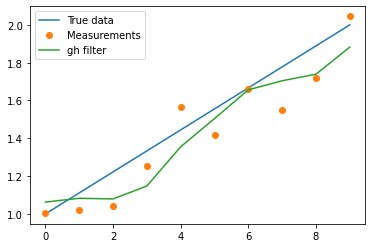

In [37]:
plt.plot(data, label="True data")
plt.plot(noisy, "o", label="Measurements")
plt.plot(filtered, label="gh filter")
plt.legend()

In [41]:
def x(t):  # function I want to track (QGT!)
    return np.log(t + 1) * np.cos(np.sin(t ** 2))

In [42]:
t = np.linspace(0, 3, 100)
data = x(t)
noisy = data + (np.random.random(data.size) - 0.5) / 2

In [62]:
filtered = g_h_filter(noisy, x0=data[0], dx=0., g=0.2, h=0)

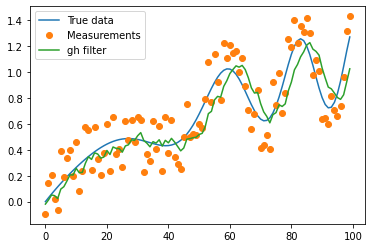

In [63]:
plt.plot(data, label="True data")
plt.plot(noisy, "o", label="Measurements")
plt.plot(filtered, label="gh filter")
plt.legend()

In [121]:
from qiskit.algorithms.optimizers import QNSPSA
from qiskit.algorithms.optimizers.spsa import _make_spd
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import I, Z, X
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import AerSimulator

ansatz = EfficientSU2(2, reps=1)
op = 0.1 * (Z ^ Z) - (X ^ I) - (I ^ X)

def energy(theta):
    return Statevector(ansatz.bind_parameters(theta)).expectation_value(op).real

def objective(theta):
    return energy(theta)

sim = AerSimulator()
fid = QNSPSA.get_fidelity(ansatz, sim)
optimizer = QNSPSA(fid, maxiter=100, learning_rate=0.01, perturbation=0.01)

In [134]:
def step(theta, num_samples, qgt_samples, b_samples, estimator=None):
    _, b, qgt = optimizer._point_estimate(objective, theta, 0.01, num_samples)
    qgt_samples.append(qgt)
    b_samples.append(b)
    
    if estimator is None:
        def estimator(samples):
            return _make_spd(np.mean(qgt_samples, axis=0))
        
    qgt_est = estimator(qgt_samples)
    b_est = b
    
    return np.linalg.solve(qgt_est + 0.01 * np.eye(theta.size), b_est).real

In [189]:
from surfer.qfi import ReverseQFI


In [217]:
theta = np.zeros(ansatz.num_parameters)
optimizer._nfev = 0
qgt_samples = [ReverseQFI().compute(ansatz, theta)]
b_samples = []
# energies = []

In [218]:
energies = []
for _ in range(50):
    dtheta = step(theta, 10, qgt_samples, b_samples)
    theta = theta - 0.01 / 2 * dtheta
    energies.append(energy(theta))

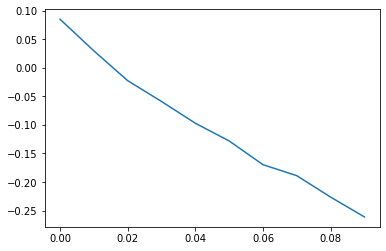

In [192]:
plt.plot(0.01 * np.arange(len(energies)), energies)

In [292]:
def gh_estimator(samples):
    qgts = g_h_filter(samples, x0=samples[0], dx=0.0, g=1, h=0, dt=0.01)
    return _make_spd(qgts[-1])

In [296]:
theta = np.zeros(ansatz.num_parameters)
optimizer._nfev = 0
qgt_samples = [ReverseQFI().compute(ansatz, theta)]
b_samples = []

In [297]:
gh_energies = []
for _ in range(50):
    dtheta = step(theta, 10, qgt_samples, b_samples, gh_estimator)
    theta = theta - 0.01 / 2 * dtheta
    gh_energies.append(energy(theta))

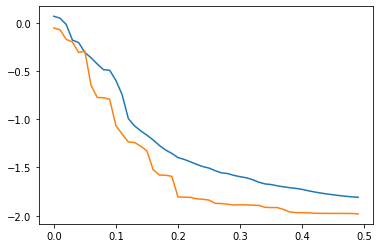

In [298]:
plt.plot(0.01 * np.arange(len(energies)), energies)
plt.plot(0.01 * np.arange(len(gh_energies)), gh_energies)

In [ ]:
def poly_estimator()